In [4]:
import math
import random
import matplotlib.pyplot as plt

def calculate_R(m_n, psi):
    return (0.357 * m_n) / (math.cos(psi) ** 2)


def calculate_H_g(i, r_g, R, alpha_n):
    return (r_g / R) * ((i + 1) / (2 * math.cos(alpha_n)))

def calculate_H_p(i, r_a, R, alpha_t):
    return (r_a / R) * ((i - 1) / (2 * math.cos(alpha_t)))

# Define objective functions
def objective_function_1(x):
    """ Maximization of efficiency of gear pair
    f1 = Efficiency(η) = 100 - PL
    where PL = Power Loss
    """
    z1, z2, alpha_t, alpha_n, m_t, m_n, psi = x
    d1 = z1 * m_t  # Pitch diameter of the large end of bevel pinion in mm
    d2 = z2 * m_t  # Pitch diameter of the large end of bevel gear in mm
    r_a = d1 / 2  # Radius of addendum circle for pinion
    r_g = d2 / 2  # Radius of addendum circle for gear
    i = z2 / z1  # Gear ratio
    R = calculate_R(m_n, psi)  # Equivalent radius of curvature
    H_g = calculate_H_g(i, r_g, R, alpha_n)  # Geometry factor for gear
    H_p = calculate_H_p(i, r_a, R, alpha_t)  # Geometry factor for pinion
    cos_psi = math.cos(psi)
    cos_alpha_t = math.cos(alpha_t)
    cos_alpha_n = math.cos(alpha_n)
    power_loss = 50 * (cos_psi / cos_alpha_t) ** 2 * ((H_g ** 2 + H_p ** 2) / (H_g + H_p)) * cos_alpha_n * (1 / cos_alpha_n - psi * math.tan(alpha_n))
    efficiency = 100 - power_loss
    return efficiency

def objective_function_2(x):
    """ Minimization of weight of the spiral bevel gear pair
    f2 = Total Weight W = W1 + W2
    Where, W1 = Weight of pinion = 42.438 ρ m^2 z1
           W2 = Weight of gear = 68.52 ρ m^2 z2
    """
    z1, z2, alpha_t, alpha_n, m_t, m_n, psi = x
    rho = 7850  # Density of steel (kg/m^3)
    W1 = 42.438 * rho * m_t**2 * z1
    W2 = 68.52 * rho * m_t**2 * z2
    total_weight = W1 + W2
    return total_weight

def objective_function_3(x):
    """ Minimization of pitch cone distance of gear pair
    f3 = Rc = 0.5m,z,√i² +1
    """
    m, z1, z2, _, _, _, _ = x
    i = z2 / z1
    Rc = calculate_Rc(m, z1, i)
    return Rc

# Define constraints
def bending_stress_constraint(x):
    z1, z2, alpha_t, alpha_n, m_t, m_n, psi = x
    R = calculate_R(m_n, psi)
    i = z2 / z1
    b = 30  # Face width
    bm = 0.8  # Helix angle factor
    yt = 0.3  # Tooth form factor
    Mt = 1000  # Allowable bending moment
    sigma_b_allowable = 300  # Allowable bending stress
    sigma_b = (0.7 * R * ((i**2 + 1) / i) * Mt) / ((R - 0.5 * b) * (bm * yt))
    return sigma_b <= sigma_b_allowable

def crushing_stress_constraint(x):
    z1, z2, alpha_t, alpha_n, m_t, m_n, psi = x
    R = calculate_R(m_n, psi)
    i = z2 / z1
    b = 30  # Face width
    E = 200000  # Young's modulus of elasticity
    Mt = 1000  # Allowable bending moment
    sigma_c_allowable = 1200  # Allowable crushing stress
    sigma_c = (0.72 * ((i**2 + 1)**0.5 / (R - 0.5 * b))) * (i * b / E * Mt)
    return sigma_c <= sigma_c_allowable

def cone_distance_constraint(x):
    z1, _, _, _, _, _, _ = x
    R = calculate_R(x[5], x[6])
    Rmin = 41.4885 / ((0.357 * z1 - 0.5)**2)
    return Rmin <= R

def average_module_constraint(x):
    z1, z2, _, alpha_n, _, _, _ = x
    i = z2 / z1
    Mt = 1000  # Allowable bending moment
    yt = 0.3  # Tooth form factor
    sigma_t = 600  # Allowable shear stress
    beta_n = alpha_n
    mn = 1.15 * math.cos(beta_n) * np.sqrt(Mt / (yt * sigma_t * z1 * i * z1))
    return mn >= 1.15 * math.cos(beta_n) * np.sqrt(Mt / (yt * sigma_t * z1 * i * z1))

def gear_ratio_constraint(x):
    z1, z2, _, _, _, _, _ = x
    i = z2 / z1
    return i == 4.778

def calculate_Rc(m, z1, i):
    """
    Calculate the pitch cone distance of the gear pair.

    Args:
        m (float): The module of the gear pair.
        z1 (int): The number of teeth on the pinion.
        i (float): The gear ratio.

    Returns:
        Rc (float): The pitch cone distance of the gear pair.
    """
    Rc = 0.5 * m * z1 * math.sqrt(i**2 + 1)
    return Rc

# Function to generate initial population
def generate_initial_population(pop_size, num_variables):
    population = []
    for _ in range(pop_size):
        solution = [random.uniform(1, 10) for _ in range(num_variables)]  # Adjust range as per requirements
        population.append(solution)
    return population
def fast_non_dominated_sort(population, objective_functions):
    """
    Fast Non-dominated Sorting Algorithm for NSGA-II.

    Args:
        population (list): A list of individuals in the population.
        objective_functions (list): A list of objective functions.

    Returns:
        fronts (list): A list of fronts containing non-dominated individuals.
    """
    n_individuals = len(population)
    n_objectives = len(objective_functions)

    # Initialize the fronts list
    fronts = [[] for _ in range(n_individuals)]

    # Initialize the dominance count for each individual
    dominance_count = [0] * n_individuals

    # Initialize the dominance matrix
    dominance_matrix = np.zeros((n_individuals, n_individuals))

    # Calculate the dominance matrix
    for i in range(n_individuals):
        for j in range(n_individuals):
            if i != j:
                dominated = True
                for k in range(n_objectives):
                    if objective_functions[k](population[i]) > objective_functions[k](population[j]):
                        dominated = False
                        break
                    elif objective_functions[k](population[i]) < objective_functions[k](population[j]):
                        dominance_matrix[i][j] = 1
                if dominated:
                    dominance_count[i] += 1

    # Initialize the front index
    front_index = 0

    # Assign individuals to fronts based on dominance count
    while front_index < n_individuals:
        for i in range(n_individuals):
            if dominance_count[i] == 0:
                fronts[front_index].append(population[i])
                for j in range(n_individuals):
                    if dominance_matrix[i][j] == 1:
                        dominance_count[j] -= 1
        front_index += 1

    return fronts

# Main NSGA-II algorithm
def nsga2(population, pop_size, max_gen):
    """
    NSGA-II algorithm for multi-objective optimization.

    Args:
        population (list): A list of individuals in the population.
        pop_size (int): The population size.
        max_gen (int): The maximum number of generations.

    Returns:
        population (list): The final population after optimization.
    """
    # Evaluation
    feasible_population = [ind for ind in population if all(constraint(ind) for constraint in constraints)]
    if not feasible_population:
        print("No feasible solutions found. Returning initial population.")
        return population

    # Rank individuals based on dominance
    fronts = fast_non_dominated_sort(feasible_population, objective_functions)

    # Select individuals for the next generation based on crowding distance
    next_population = []
    for front in fronts:
        if len(next_population) + len(front) <= pop_size:
            next_population.extend(front)
        else:
            sorted_front = sorted(front, key=lambda ind: crowding_distance(ind, objective_functions), reverse=True)
            next_population.extend(sorted_front[:pop_size - len(next_population)])
            break

    # If the population size is still not met, fill the remaining slots with individuals from the last front
    if len(next_population) < pop_size:
        remaining_front = fronts[-1]
        next_population.extend(remaining_front[:pop_size - len(next_population)])

    # Crossover and mutation
    for i in range(0, len(next_population), 2):
        if i < pop_size - 1 and random.random() < crossover_prob:
            offspring = crossover(next_population[i], next_population[i+1], crossover_type)
            offspring[0] = mutate(offspring[0], mutation_rate)
            offspring[1] = mutate(offspring[1], mutation_rate)
            next_population[i:i+2] = offspring

    return next_population
    
# Function to optimize
def optimize(pop_size, max_gen):
    # Initialization
    population = generate_initial_population(pop_size, num_variables)
    # Main loop
    for gen in range(max_gen):
        # NSGA-II
        population = nsga2(population, pop_size, max_gen)
    return population

# Parameters
pop_size = 20
max_gen = 100
num_variables = 7
objective_functions = [objective_function_1, objective_function_2, objective_function_3]
constraints = [bending_stress_constraint, crushing_stress_constraint, cone_distance_constraint,
               average_module_constraint, gear_ratio_constraint]

# Optimization
final_population = optimize(pop_size, max_gen)


No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial populatio

No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial populatio

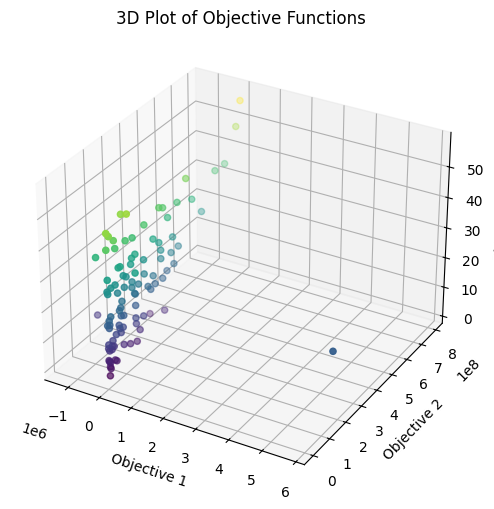

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Generate the final population
pop_size = 100
max_gen = 100
final_population = optimize(pop_size, max_gen)

# Extract the objective function values for each individual in the final population
objective_values = [[objective_function_1(ind), objective_function_2(ind), objective_function_3(ind)] for ind in final_population]

# Plot the objective functions on a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([obj[0] for obj in objective_values], [obj[1] for obj in objective_values], [obj[2] for obj in objective_values], c=[obj[2] for obj in objective_values])
ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_zlabel('Objective 3')
ax.set_title('3D Plot of Objective Functions')

plt.show()

In [70]:
import numpy as np

class Particle:
    def __init__(self, num_variables):
        self.position = np.random.uniform(1, 10, size=num_variables)
        self.velocity = np.random.uniform(-1, 1, size=num_variables)
        self.best_position = self.position.copy()
        self.best_fitness = float('inf')

def evaluate_objectives(individual):
    return (objective_function_1(individual),
            objective_function_2(individual),
            objective_function_3(individual))

def evaluate_fitness(individual):
    if all(constraint(individual) for constraint in constraints):
        objectives = evaluate_objectives(individual)
        return sum(objectives)
    else:
        return float('inf')  # Penalize infeasible solutions

def pso(pop_size, max_gen, num_variables):
    population = [Particle(num_variables) for _ in range(pop_size)]
    global_best_position = np.random.uniform(1, 10, size=num_variables)  # Initialize to random position
    global_best_fitness = float('inf')
    
    for gen in range(max_gen):
        for particle in population:
            fitness = evaluate_fitness(particle.position)
            
            if fitness < particle.best_fitness:
                particle.best_position = particle.position.copy()
                particle.best_fitness = fitness
                
            if fitness < global_best_fitness:
                global_best_position = particle.position.copy()
                global_best_fitness = fitness
                
            # Update particle velocity and position
            w = 0.5  # Inertia weight
            c1 = 1.5  # Cognitive weight
            c2 = 1.5  # Social weight
            r1 = np.random.uniform(0, 1, size=num_variables)
            r2 = np.random.uniform(0, 1, size=num_variables)
            particle.velocity = (w * particle.velocity +
                                 c1 * r1 * (particle.best_position - particle.position) +
                                 c2 * r2 * (global_best_position - particle.position))
            particle.position += particle.velocity
            
    return global_best_position

# Define parameters
pop_size = 20
max_gen = 100
num_variables = 7

# Run PSO
best_solution = pso(pop_size, max_gen, num_variables)
print("Best solution found:", best_solution)


Best solution found: [4.85915644 4.43890578 2.14042045 3.19839997 1.71407425 3.72572474
 7.6753432 ]


C:\Users\Dell\AppData\Local\Temp\ipykernel_34040\4249057106.py:96: RuntimeWarning: invalid value encountered in sqrt
  mn = 1.15 * math.cos(beta_n) * np.sqrt(Mt / (yt * sigma_t * z1 * i * z1))
C:\Users\Dell\AppData\Local\Temp\ipykernel_34040\4249057106.py:97: RuntimeWarning: invalid value encountered in sqrt
  return mn >= 1.15 * math.cos(beta_n) * np.sqrt(Mt / (yt * sigma_t * z1 * i * z1))


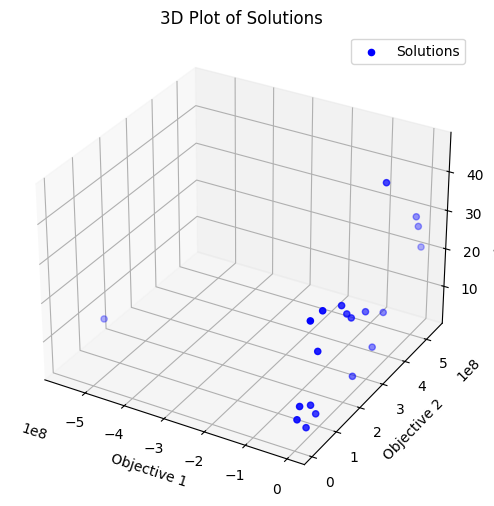

In [72]:
from mpl_toolkits.mplot3d import Axes3D

# Plot the solutions in 3D space
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract each objective from the objectives array
objective1 = objectives[:, 0]
objective2 = objectives[:, 1]
objective3 = objectives[:, 2]

# Plot each objective on its corresponding axis
ax.scatter(objective1, objective2, objective3, c='b', marker='o', label='Solutions')

# Set labels for each axis
ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_zlabel('Objective 3')

# Set the title of the plot
plt.title('3D Plot of Solutions')

# Display legend
plt.legend()

# Show plot
plt.show()
